In [0]:
!curl https://download.pytorch.org/tutorial/data.zip -o data.zip
!unzip data.zip

In [0]:
from io import open
import glob
import os
import unicodedata
import string

In [0]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

In [0]:
def find_files(path):
    return glob.glob(path)

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)

In [0]:
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [7]:
category_lines = {}
all_categories = []

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicode_to_ascii("O'Néàl"))


# categories: 18 ['English', 'Russian', 'German', 'Czech', 'Scottish', 'Arabic', 'Dutch', 'Japanese', 'Vietnamese', 'Polish', 'Spanish', 'Korean', 'French', 'Portuguese', 'Irish', 'Greek', 'Chinese', 'Italian']
O'Neal


In [0]:
import torch
import torch.nn as nn

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
import random

def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

In [0]:
def category_tensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

In [0]:
def input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [0]:
def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

In [0]:
def random_training_example():
    cat, line = random_training_pair()
    cat_tensor = category_tensor(category)
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return cat_tensor, input_line_tensor, target_line_tensor

In [0]:
criterion = nn.NLLLoss()
lr = 0.0005

In [0]:
def train(cat_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(cat_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
        
    return output, loss.item() / input_line_tensor.size(0)

In [0]:
import time
import math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [22]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*random_training_example())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 14s (5000 5%) 3.1978
0m 28s (10000 10%) 2.5334
0m 41s (15000 15%) 3.7714
0m 54s (20000 20%) 2.3851
1m 7s (25000 25%) 2.8589
1m 20s (30000 30%) 2.6846
1m 34s (35000 35%) 2.9324
1m 47s (40000 40%) 2.2378
2m 2s (45000 45%) 1.6734
2m 15s (50000 50%) 2.6990
2m 28s (55000 55%) 2.2709
2m 41s (60000 60%) 3.0719
2m 55s (65000 65%) 3.0720
3m 9s (70000 70%) 2.2030
3m 22s (75000 75%) 2.8821
3m 35s (80000 80%) 1.6827
3m 47s (85000 85%) 2.5924
4m 0s (90000 90%) 2.0730
4m 14s (95000 95%) 2.3070
4m 28s (100000 100%) 2.0602


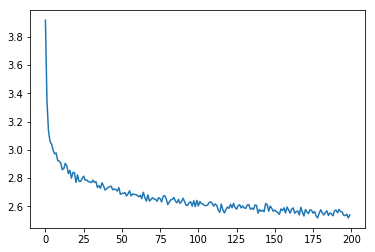

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [30]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        cat_tensor = category_tensor(category)
        input = input_tensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(cat_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = input_tensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rong
Uang
Shang
Gander
Eras
Rong
Shanger
Pang
Ang
Chaman
Hang
Irovaki
